### aim: 

### date: 

In [91]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [92]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [93]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### list of data structures 


| bio/iron data    | cchem data | light-lim parameters | dataset name |
| -------- | ------- | --- | --- |
| CLQ example  | CLQ example     | 1 (no light lim) | ./data/BOE-inputs/BOE-INPUT-CLQtest.nc |
| maredat/geotraces | glodap (adjusted)     | era5| ./data/BOE-inputs/BOE-INPUT-MEDUSA.nc |
| medusa    | medusa    | era5 | ./data/BOE-inputs/BOE-INPUT-OBS.nc |


#### data structure for boe - populated with CLQ dummy data

In [94]:
test = False

tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/'
savenam = f'{tdir}BOE-INPUT-CLQtest.nc'
print(f'{savenam} making it? {test}')

if test:
    
    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)

    #tdir = outdir
    
    
    data_vars = {


            ### bgc gradients
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }
    
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/nput-nc-for-BOEcalc-revised.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.mn_kg[:] = mn_kg; ds.grad_dDICdz[:] = grad_dDICdz; ds.grad_DIC_surfdeep[:] = grad_DIC_surfdeep;
    ds.grad_dFedz[:] = grad_dFedz; ds.grad_dFev[:] = grad_dFev; ds.mu_L[:] = mu_L;
    ds.dmudFe[:] = dmudFe; ds.diatconc[:] = diatconc; ds.mn_SST[:] = mn_SST;
    ds.mn_Revfact[:] = mn_Revfact; ds.mn_DIC[:] = mn_DIC; 
    ds.mn_TA[:] = mn_TA; ds.mn_pCO2[:] = mn_pCO2;
    
    ds.to_netcdf(savenam)

/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/BOE-INPUT-CLQtest.nc making it? False


### make a light limitation curve and get seasonal means

Text(0.5, 1.0, 'scaled light limitation curve')

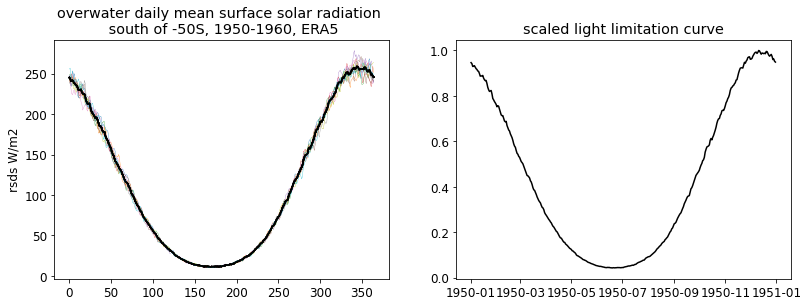

In [95]:
llim = np.zeros([10,365])

for i in range(0,10):
    yr = 1950+i
    w = xr.open_dataset(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/bulk_{yr}_11_era5_daily.nc',\
                        decode_times=False)

    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tv = w.rsds.isel(y = slice(0,37)).weighted(tmesh['csize'].isel(y = slice(0,37))).mean(dim = ['x','y'])
    
    llim[i,:] = tv.values[0:365]

    
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,10):
    axs[0].plot(np.arange(0,365,1),llim[i,:], linewidth = 0.3)
    axs[0].plot(np.mean(llim, axis =0), color = 'k')

axs[0].set_ylabel('rsds W/m2')
axs[0].set_title('overwater daily mean surface solar radiation \n south of -50S, 1950-1960, ERA5')
    
###

rsds = np.mean(llim, axis =0)
rsds_scal = rsds/np.max(rsds)

yr = 1950
time_counter = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left')


savenam = 'test2.nc'
data_vars = {'llim':(['time_counter'], rsds_scal,
{'units': 'µatm',
'long_name':'Surface ocean pCO2'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], time_counter),}
# define global attributes
attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)

axs[1].plot(ds.time_counter,ds.llim, color = 'k')
axs[1].set_ylabel('')
axs[1].set_title('scaled light limitation curve')
  
#ds.to_netcdf(savenam)

In [96]:
tmuL = np.zeros([3,5,2])

for i in range(0,3): #time periods 
    for j in range(0,2): #scenarios
        
        tmuL[i,0,j] = np.mean(ds.llim.values) ## full year
        
        tmuL[i,1,j] = ds.llim.sel(time_counter=(ds['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().values[0]
        tmuL[i,2,j] = ds.llim.sel(time_counter=(ds['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().values[0]
        tmuL[i,3,j] = ds.llim.sel(time_counter=(ds['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().values[0]
        tmuL[i,4,j] = ds.llim.sel(time_counter=(ds['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().values[0]

### medusa dataset

In [97]:

test = False
save = True

tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/'
savenam = f'{tdir}BOE-INPUT-MEDUSA.nc'
print(f'{savenam} making it? {test}')


if test:
    
    def make_yearlist(yrst, yrend, scen):

        tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            yr = yrs[i]

            t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
            ylist.append(t2[0])

        return ylist
    
    def make_yearlist_bio(yrst, yrend, scen):

        tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            yr = yrs[i]

            t2 = glob.glob(f'{tdir}biol-param-medusa_scen-{scen}-{yr}.nc')
            ylist.append(t2[0])

        return ylist

    ty_1A = make_yearlist(1950,2099,'1A')
    ty_1B = make_yearlist(1950,2099,'1B')

    td_1A = xr.open_mfdataset(ty_1A)
    td_1B = xr.open_mfdataset(ty_1B)
    
    ty_1A_bio = make_yearlist_bio(1950,2099,'1A')
    ty_1B_bio = make_yearlist_bio(1950,2099,'1B')

    td_1A_bio = xr.open_mfdataset(ty_1A_bio)
    td_1B_bio = xr.open_mfdataset(ty_1B_bio)
    

    mu_L = tmuL # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is



    
    data_vars = {


            ### bgc gradients

        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }
    
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/input-nc-for-BOEcalc-revised.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.mn_kg[:] = mn_kg; 
    ds.mu_L[:] = mu_L;
    ds.dmudFe[:] = dmudFe;
    

    
    ### for this stuff we have data from the model
    
    scenarioar = ['ssp1','ssp3']
    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']

    for p in periodar:
        ind = 0 
        tpe = int(p[0:4])
        for s in seasonar:
            for sc in scenarioar:

                print(f'{p} (starts {tpe}), {s}, {sc}')


                if sc == 'ssp1': td = td_1A; td_bio = td_1A_bio;
                if sc == 'ssp3': td = td_1B; td_bio = td_1B_bio;
                
                td = td.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))

                if s == 'FY':
                    td = td.groupby('time_counter.year').mean()
                else:
                    td = td.sel(time_counter=(td['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()
                    
                td_bio = td_bio.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))
                
                if s == 'FY':
                    td_bio = td_bio.groupby('time_counter.year').mean()
                else:
                    td_bio = td_bio.sel(time_counter=(td_bio['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()

        
                ds.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }] = td_bio.dmudFe[:,0].mean().values; #this is mislabeled
                ds.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }] = td_bio.grad_dFev[:,0].mean().values; 
                ds.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }] = td_bio.diatconc[:,0].mean().values; 

                ds.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_pCO2[:,0].mean().values; 
                ds.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_dDICdz[:,0].mean().values; 
                ds.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_Revfact[:,0].mean().values; 
                ds.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_DIC_surfdeep[:,0].mean().values; 
                ds.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_DIC[:,0].mean().values; 
                ds.mn_TA.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_TA[:,0].mean().values; 
                ds.mn_SST.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_SST[:,0].mean().values; 
     
    if save:
        ds.to_netcdf(savenam)

/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/BOE-INPUT-MEDUSA.nc making it? False


### glodap/maredat/geotraces dataset

In [98]:
# season DJF, median 0.019 mmol C/m3, mean 3.293, n.obs = 1181
# season MAM, median 0.077 mmol C/m3, mean 0.38, n.obs = 512
# season JJA, median 0.052 mmol C/m3, mean 0.308, n.obs = 23
# season SON, median 0.042 mmol C/m3, mean 2.406, n.obs = 284


# surface (0-20m) median is 0.14434000849723816, median at 180-220m is 0.24459899961948395
# median at 800-1200m is 0.37073200941085815, at 1600-2400m is 0.4292680025100708
# surface 200m gradient is 0.0005276789006433989
# 1000-surface is 0.22639200091362

tdiatconc = np.zeros([3,5,2])

for i in range(0,3): #time periods 
    for j in range(0,2): #scenarios
        
        tdiatconc[i,0,j] = np.mean([3.293,0.38,0.308,2.406]) ## full year
        
        tdiatconc[i,1,j] = 3.293
        tdiatconc[i,2,j] = 0.38
        tdiatconc[i,3,j] = 0.308
        tdiatconc[i,4,j] = 2.406

In [99]:

test = False
save = True

tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/'
savenam = f'{tdir}BOE-INPUT-OBS.nc'
print(f'{savenam} making it? {test}')

if test:
    
    def make_yearlist(yrst, yrend, scen):

        tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            yr = yrs[i]

            t2 = glob.glob(f'{tdir}cchem-param-glodap_sdp_scen-{scen}-{yr}.nc')
            ylist.append(t2[0])

        return ylist
    


    ty_1A = make_yearlist(1950,2099,'1A')
    ty_1B = make_yearlist(1950,2099,'1B')

    td_1A = xr.open_mfdataset(ty_1A)
    td_1B = xr.open_mfdataset(ty_1B)
    

    mu_L = tmuL # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is




    
    data_vars = {


            ### bgc gradients

        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }
    
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/input-nc-for-BOEcalc-revised.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    
    ds.mn_kg[:] = mn_kg; 
    ds.mu_L[:] = mu_L;
    ds.dmudFe[:] = dmudFe;
    
    #see scratch/BOE-SOcarbon/iron-cycle.ipynb
    ds.grad_dFedz[:] = 0.00052768
    ds.grad_dFev[:] = 0.226392
    ds.diatconc[:] = tdiatconc #see scratch/BOE-SOcarbon/Maredat-diatoms.ipynb
    
    
    ### for this stuff we have data from the model
    
    scenarioar = ['ssp1','ssp3']
    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']

    for p in periodar:
        ind = 0 
        tpe = int(p[0:4])
        for s in seasonar:
            for sc in scenarioar:

                print(f'{p} (starts {tpe}), {s}, {sc}')


                if sc == 'ssp1': td = td_1A; td_bio = td_1A_bio;
                if sc == 'ssp3': td = td_1B; td_bio = td_1B_bio;
                
                td = td.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))

                if s == 'FY':
                    td = td.groupby('time_counter.year').mean()
                else:
                    td = td.sel(time_counter=(td['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()
                    
        
                #ds.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }] = td_bio.dmudFe[:,0].mean().values; #this is mislabeled
                #ds.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }] = td_bio.grad_dFev[:,0].mean().values; 
                
                
                ds.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_pCO2[:,0].mean().values; 
                ds.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_dDICdz[:,0].mean().values; 
                ds.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_Revfact[:,0].mean().values; 
                ds.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }] = td.grad_DIC_surfdeep[:,0].mean().values; 
                ds.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_DIC[:,0].mean().values; 
                ds.mn_TA.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_TA[:,0].mean().values; 
                ds.mn_SST.loc[{'period':p, 'season':s, 'scenario': sc }] = td.mn_SST[:,0].mean().values; 
     
    if save:
        ds.to_netcdf(savenam)

/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/BOE-inputs/BOE-INPUT-OBS.nc making it? False


In [101]:
ds_clq = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-CLQtest.nc')
ds_medusa = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-MEDUSA.nc')
ds_obs = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-OBS.nc')

In [112]:
df = ds_obs.to_dataframe().to_csv('./data/BOE-inputs/BOE-INPUT-OBS.csv')
df = ds_medusa.to_dataframe().to_csv('./data/BOE-inputs/BOE-INPUT-MEDUSA.csv')
df = ds_clq.to_dataframe().to_csv('./data/BOE-inputs/BOE-INPUT-CLQtest.csv')

In [110]:
df

grad_dFedz  grad_dFev      mu_L  dmudFe  diatconc  \
period    scenario season                                                      
1950-2000 ssp1     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   
          ssp3     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   
2000-2050 ssp1     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   
          ssp3     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   
2050-2100 ssp1     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   
          ssp3     FY        0.000528   0.226392  0.438275    0.59   1.59675   
                   DJF       0.000528   0.226392  0.838576    0.59   3.29300   
                   MAM       0.000528   0.226392  0.225533    0.59   0.38000   
                   JJA       0.000528   0.226392  0.085672    0.59   0.30800   
                   SON       0.000528   0.226392  0.613930    0.59   2.40600   

                           mn_kg    mn_SST  mn_Revfact    mn_DIC        mn_TA  \
period    scenario season                                                       
1950-2000 ssp1     FY      0.065  1.811661   13.112826  2170.100  2349.517227   
                   DJF     0.065  2.627423   13.106389  2170.100  2349.517227   
                   MAM     0.065  2.390452   13.106045  2170.100  2349.517227   
                   JJA     0.065  1.211319   13.119239  2170.100  2349.517227   
                   SON     0.065  1.017448   13.119629  2170.100  2349.517227   
          ssp3     FY      0.065  1.811661   13.112826  2170.100  2349.517227   
                   DJF     0.065  2.627423   13.106389  2170.100  2349.517227   
                   MAM     0.065  2.390452   13.106045  2170.100  2349.517227   
                   JJA     0.065  1.211319   13.119239  2170.100  2349.517227   
                   SON     0.065  1.017448   13.119629  2170.100  2349.517227   
2000-2050 ssp1     FY      0.065  2.286886   14.622331  2209.190  2349.517227   
                   DJF     0.065  3.064552   14.610182  2209.190  2349.517227   
                   MAM     0.065  2.895129   14.610407  2209.190  2349.517227   
                   JJA     0.065  1.704737   14.633249  2209.190  2349.517227   
                   SON     0.065  1.483126   14.635484  2209.190  2349.517227   
          ssp3     FY      0.065  2.284092   14.845083  2214.265  2349.517227   
        

<xarray.DataArray 'mn_DIC' (season: 5)>
array([2120., 2120., 2120., 2120., 2120.])
Coordinates:
    period    <U9 '1950-2000'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
    scenario  <U4 'ssp1'
Attributes:
    units:    
<xarray.DataArray 'mn_DIC' (season: 5)>
array([2120., 2120., 2120., 2120., 2120.])
Coordinates:
    period    <U9 '2000-2050'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
    scenario  <U4 'ssp1'
Attributes:
    units:    
<xarray.DataArray 'mn_DIC' (season: 5)>
array([2120., 2120., 2120., 2120., 2120.])
Coordinates:
    period    <U9 '2050-2100'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
    scenario  <U4 'ssp1'
Attributes:
    units:    
<xarray.DataArray 'mn_DIC' (season: 5)>
array([2120., 2120., 2120., 2120., 2120.])
Coordinates:
    period    <U9 '1950-2000'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
    scenario  <U4 'ssp3'
Attributes:
    units:    
<xarray.DataArray 'mn_DIC' (season: 5)>
array([2120.

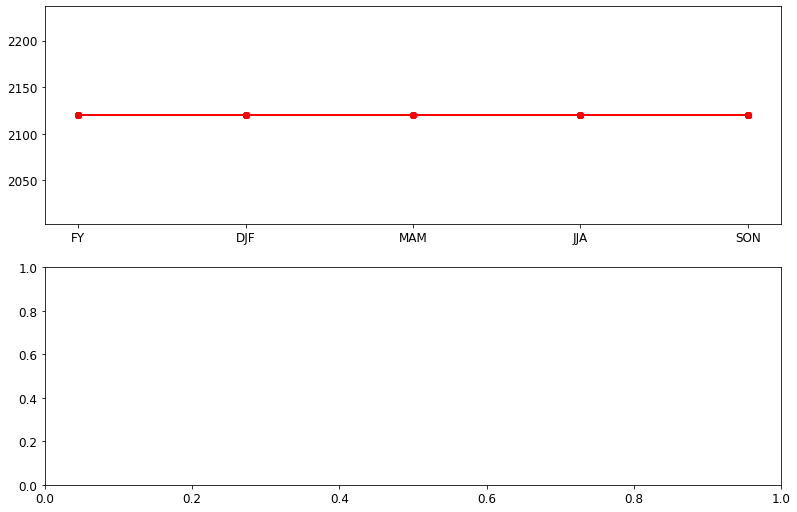

In [108]:
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ds = ds_clq
color = 'r'
var = 'mn_DIC'
lines = []

for s in range(2):
    
    for p in range(3):
        tplot = ds[var][p,:,s]
        print(tplot)
        axs[0].plot(tplot.season, tplot, color = 'r', marker = 'o', linestyle = )